In [1]:
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

/tmp/dcs-tmp.u2164966/ipykernel_81677/1179451061.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


In [2]:
df.head()

,incident_count,date_created,hour_created,max_final_priority,inc_resourced,scrs_crime_inc,multi_member_ward,datazone,dzone_code,service_code_description
0,2,2023-08-11,7,PROMPT,False,False,Dennistoun,Carntyne West and Haghill - 03,S01010244,ROAD TRAFFIC COLLISION
1,2,2023-02-16,20,PROMPT,True,False,Lochee,Charleston - 04,S01007848,ASSIST MEMBER OF THE PUBLIC
2,2,2024-09-05,0,STANDARD,False,True,Leith Walk,South Leith - 05,S01008796,THEFT
3,2,2024-09-02,14,PROMPT,True,False,Almond,"Ratho, Ingliston and Gogar - 01",S01008993,EXTERNAL AGENCY REQUEST
4,2,2022-04-12,19,PROMPT,True,False,Paisley North West,Paisley North - 06,S01012158,EXTERNAL AGENCY REQUEST


In [3]:
# drop tables that are not required
df = df.drop(columns=['incident_count', 'datazone', 'dzone_code'])
df.columns

Index(['date_created', 'hour_created', 'max_final_priority', 'inc_resourced',
       'scrs_crime_inc', 'multi_member_ward', 'service_code_description'],
      dtype='object')

## Preprocessing

In [4]:
import pandas as pd

# make sure date_created is datetime
df['date_created'] = pd.to_datetime(df['date_created'])

# compute day offset from min date, then +1
min_date = df['date_created'].min()  # 2022-04-01 00:00:00
df['date_seq'] = (df['date_created'] - min_date).dt.days + 1

In [5]:
# compute min/max of each
min_date = df['date_created'].min()
max_date = df['date_created'].max()
min_seq  = df['date_seq'].min()
max_seq  = df['date_seq'].max()

# grab the corresponding dates from the mapped column
mapped_min_date = df.loc[df['date_seq'] == min_seq, 'date_created'].iloc[0]
mapped_max_date = df.loc[df['date_seq'] == max_seq, 'date_created'].iloc[0]

# sanity‐check
print(f"earliest actual date: {min_date}, mapped date at seq {min_seq}: {mapped_min_date}")
print(f" latest actual date: {max_date}, mapped date at seq {max_seq}: {mapped_max_date}")

assert mapped_min_date == min_date, "Min sequence does NOT map to the earliest date!"
assert mapped_max_date == max_date, "Max sequence does NOT map to the latest date!"

print("✔️  Date‐sequence mapping looks good!")


earliest actual date: 2022-04-01 00:00:00, mapped date at seq 1: 2022-04-01 00:00:00
 latest actual date: 2025-03-31 00:00:00, mapped date at seq 1096: 2025-03-31 00:00:00
✔️  Date‐sequence mapping looks good!


In [6]:
# dropping date_created column
df = df.drop("date_created", axis=1)

In [7]:
df.dtypes

hour_created                   int32
max_final_priority          category
inc_resourced                   bool
scrs_crime_inc                  bool
multi_member_ward           category
service_code_description    category
date_seq                       int64
dtype: object

## CTGAN

In [8]:
pip install --no-user sdv

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip show sdv

Name: sdv
Version: 1.23.0
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: 
Author: 
Author-email: "DataCebo, Inc." <info@sdv.dev>
License: BSL-1.1
Location: /dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages
Requires: boto3, botocore, cloudpickle, copulas, ctgan, deepecho, graphviz, numpy, pandas, platformdirs, pyyaml, rdt, sdmetrics, tqdm
Required-by: 


In [8]:
from sdv.metadata import SingleTableMetadata

bool_cols = ["inc_resourced", "scrs_crime_inc"]
cat_cols  = ["max_final_priority", "multi_member_ward", "service_code_description"]

df[bool_cols] = df[bool_cols].astype(bool)                  # force clean bool
df[cat_cols]  = df[cat_cols].astype(str)                    # cast category→object

# good practice: keep numerics int
num_cols = ["hour_created", "date_seq"]
df[num_cols] = df[num_cols].astype({"hour_created": "int32",
                                    "date_seq": "int64"})

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)    # auto detecting the metadata information from the df

In [9]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "hour_created": {
            "sdtype": "numerical"
        },
        "max_final_priority": {
            "sdtype": "categorical"
        },
        "inc_resourced": {
            "sdtype": "categorical"
        },
        "scrs_crime_inc": {
            "sdtype": "categorical"
        },
        "multi_member_ward": {
            "sdtype": "categorical"
        },
        "service_code_description": {
            "sdtype": "categorical"
        },
        "date_seq": {
            "sdtype": "numerical"
        }
    }
}

In [10]:
from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(
    metadata,
    epochs=300,
    batch_size=1024,
    pac=8,
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    cuda=True,
    verbose=True
)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:162: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/single_table/base.py:128: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [11]:
ctgan.fit(
    data=df,
)

Gen. (0.71) | Discrim. (-0.05): 100%|██████████| 300/300 [5:53:29<00:00, 70.70s/it]   


In [12]:
loss_df = ctgan.get_loss_values()
print(loss_df.head())

   Epoch  Generator Loss  Discriminator Loss
0      0       -0.393512           -0.045384
1      1       -0.325351           -0.004594
2      2       -0.177901           -0.038435
3      3       -0.244282           -0.061916
4      4       -0.106887           -0.024772


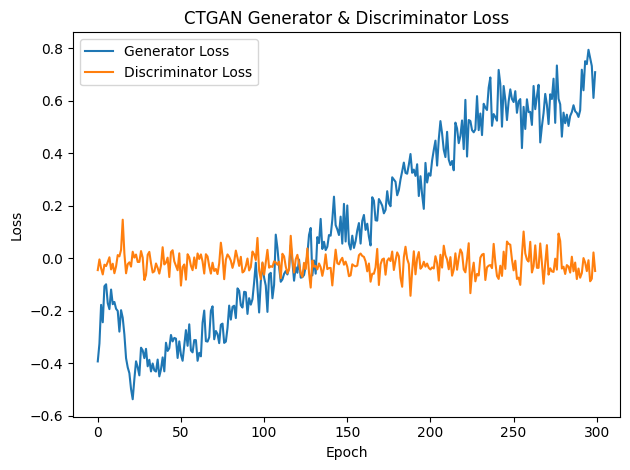

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_df['Epoch'], loss_df['Generator Loss'], label='Generator Loss')
plt.plot(loss_df['Epoch'], loss_df['Discriminator Loss'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CTGAN Generator & Discriminator Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# saving the model to a pickle file
with open('ctgan_model.pkl', 'wb') as f:
    pickle.dump(ctgan, f)
print("Model saved to ctgan_model.pkl")

Model saved to ctgan_model.pkl


## Loading the pickle file

In [22]:
# loading the model
import pickle
with open('ctgan_model.pkl', 'rb') as file:
    ctgan = pickle.load(file)

In [23]:
# a sample of 1000 data points
synthetic_df = ctgan.sample(1000)

In [24]:
synthetic_df.head()

,hour_created,max_final_priority,inc_resourced,scrs_crime_inc,multi_member_ward,service_code_description,date_seq
0,11,STANDARD,True,False,Airdrie South,ASSIST MEMBER OF THE PUBLIC,595
1,19,STANDARD,False,True,Greater Pollok,THEFT,456
2,7,STANDARD,True,True,Dunfermline North,DAMAGE,584
3,9,PROMPT,False,False,Irvine West,ABANDONED/SILENT 999 CALL,238
4,17,STANDARD,False,True,Kincorth/Nigg/Cove,THEFT,544


## Testing the similarity of the synthetic data with the real data (Initial approach)

In [25]:
len(df)

2843693

In [26]:
# Generating the same number of synthetic data points as real
synthetic_df = ctgan.sample(2843693)

In [27]:
# length of the synthetic data
len(synthetic_df)

2843693

In [28]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
synthetic_df.dtypes

hour_created                 int32
max_final_priority          object
inc_resourced                 bool
scrs_crime_inc                bool
multi_member_ward           object
service_code_description    object
date_seq                     int64
dtype: object

In [31]:
# Number of dates in synthetic data
len(synthetic_df['date_seq'].unique())

1096

In [32]:
# Number of dates in real data
len(df['date_seq'].unique())

1096

### Univariate analysis

In [36]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [37]:
def hellinger_distance(p, q, bins=20):
    """
    Compute Hellinger distance between two 1-D distributions.

    Parameters
    ----------
    p, q : 1-D arrays or pd.Series
        Samples from the real and synthetic data.
    bins : int or array-like
        If int, uses equal-width bins (good default for continuous vars).
        If you pass an explicit bin-edge array, the same edges are reused
        for both p and q.

    Returns
    -------
    float in [0, 1]
        0   → identical distributions  
        1   → maximally different
    """
    # Choose common bin edges
    if np.isscalar(bins):
        edges = np.histogram_bin_edges(np.concatenate((p, q)), bins=bins)
    else:
        edges = bins

    # Normalised histograms ⇒ empirical PMFs
    p_hist, _ = np.histogram(p, bins=edges, density=True)
    q_hist, _ = np.histogram(q, bins=edges, density=True)

    # Replace nans that can appear if column is constant
    p_hist = np.nan_to_num(p_hist)
    q_hist = np.nan_to_num(q_hist)

    return np.sqrt(0.5 * np.sum((np.sqrt(p_hist) - np.sqrt(q_hist))**2))


In [38]:
def hellinger_categorical(p, q):
    # aligned on the union of category labels
    all_cats = sorted(set(p).union(q))
    p_probs = np.array(p.value_counts(normalize=True).reindex(all_cats, fill_value=0))
    q_probs = np.array(q.value_counts(normalize=True).reindex(all_cats, fill_value=0))
    return np.sqrt(0.5 * np.sum((np.sqrt(p_probs) - np.sqrt(q_probs))**2))

In [39]:
distances = {}

for col in df.columns:
    real_col = df[col].dropna()
    synth_col = synthetic_df[col].dropna()

    if pd.api.types.is_numeric_dtype(real_col):
        d = hellinger_distance(real_col, synth_col, bins=20)
    else:
        d = hellinger_categorical(real_col, synth_col)

    distances[col] = d

hellinger_series = pd.Series(distances).sort_values()


/tmp/dcs-tmp.u2164966/ipykernel_46307/37115541.py:22: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

/tmp/dcs-tmp.u2164966/ipykernel_46307/37115541.py:27: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

/tmp/dcs-tmp.u2164966/ipykernel_46307/37115541.py:28: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



In [41]:
# Hellinger diatances for each column
hellinger_series

date_seq                    0.004423
max_final_priority          0.052552
hour_created                0.074809
multi_member_ward           0.101205
service_code_description    0.158553
scrs_crime_inc              0.210121
inc_resourced               0.306412
dtype: float64

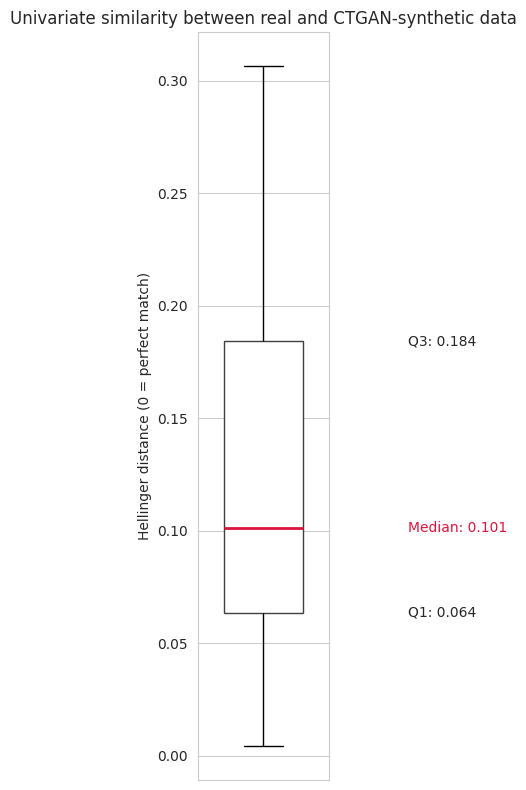

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# assume hellinger_series is a pandas Series of distances
values = hellinger_series.values

# compute quartiles
q1, med, q3 = np.quantile(values, [0.25, 0.5, 0.75])

# set a clean white background
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(6, 8))

# boxplot with colored median
sns.boxplot(
    y=values,
    width=0.6,
    showcaps=True,
    fliersize=0,
    boxprops={"facecolor": "white"},
    medianprops={"color": "crimson", "linewidth": 2},
    whiskerprops={"color": "black"},
    capprops={"color": "black"},
    ax=ax
)

# annotate the quartiles
x_pos = 1.0  # box is centered at x=1
offset = 0.04 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # small vertical offset for text

ax.text(x_pos + 0.1, q1, f"Q1: {q1:.3f}", va='center')
ax.text(x_pos + 0.1, med, f"Median: {med:.3f}", va='center', color='crimson')
ax.text(x_pos + 0.1, q3, f"Q3: {q3:.3f}", va='center')

# clean up axes
ax.set_xticks([])  
ax.set_ylabel("Hellinger distance (0 = perfect match)")
ax.set_title("Univariate similarity between real and CTGAN-synthetic data")

plt.tight_layout()
plt.show()

### Bivariate analysis

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning:

The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning:

The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning:

Th

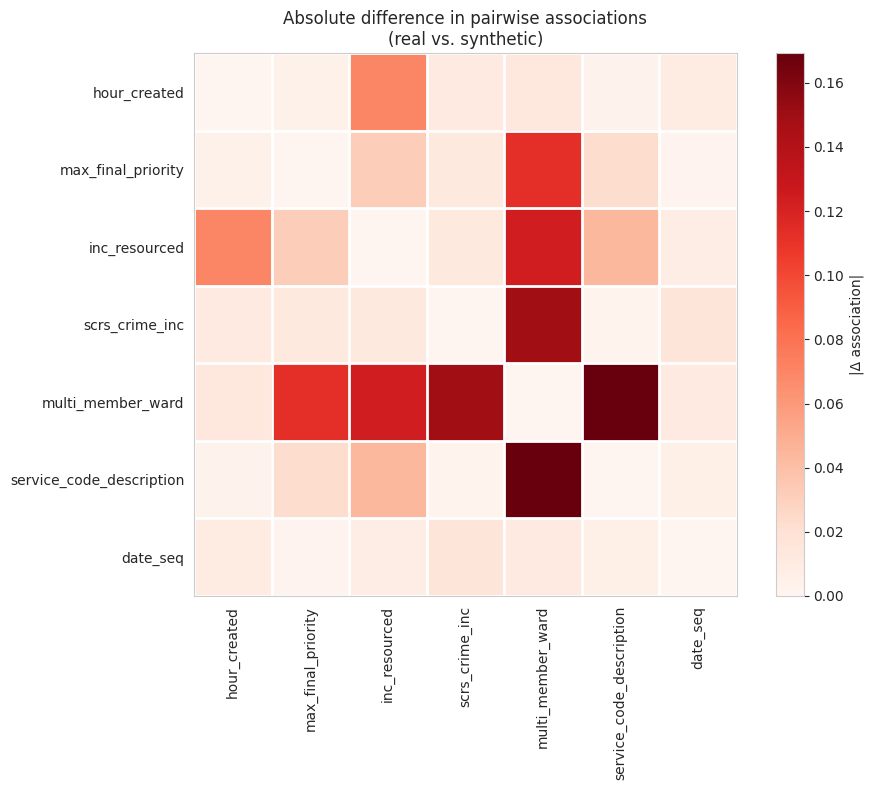

In [62]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt


# 1.  Variable-type helpers
def _is_binary(s):
    if pd.api.types.is_bool_dtype(s):
        return True
    if pd.api.types.is_numeric_dtype(s):
        u = s.dropna().unique()
        return len(u) <= 2 and set(u).issubset({0, 1})
    return False

def _var_type(s):
    if _is_binary(s):
        return "binary"
    if pd.api.types.is_numeric_dtype(s):
        return "continuous"
    return "categorical"           # object or category

# 2.  Association measuresdef _cramers_v(a, b):
    tbl  = pd.crosstab(a, b)
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n    = tbl.values.sum()
    k, r = tbl.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

def _mutual_info_cat_cont(cat, cont, n_bins=10, strategy="quantile"):
    """Normalized mutual information between a categorical and a continuous variable."""
    mask = cat.notna() & cont.notna()
    if mask.sum() == 0:
        return np.nan
    cat_codes = pd.Categorical(cat[mask]).codes                # discrete 0…K-1
    cont_binned = (
        KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
        .fit_transform(cont[mask].to_numpy().reshape(-1, 1))
        .astype(int)
        .ravel()
    )
    # NMI is symmetricscaled to [0,1]; we use the ‘min’ normalisation
    return normalized_mutual_info_score(cat_codes, cont_binned, average_method="min")

def _association(x, y, xtype, ytype):
    # continuous × continuous  → Pearson
    if xtype == ytype == "continuous":
        return pearsonr(x, y)[0]

    # one continuous & one binary  → point-biserial
    if {"binary", "continuous"} <= {xtype, ytype} and "categorical" not in {xtype, ytype}:
        return pointbiserialr(x, y)[0]

    # binary × binary  → φ (Pearson on 0/1 dummies)
    if xtype == ytype == "binary":
        return pearsonr(x, y)[0]

    # categorical × binary  → Cramér’s V
    if {"categorical", "binary"} <= {xtype, ytype}:
        return _cramers_v(x, y)

    # categorical × categorical  → Cramér’s V
    if xtype == ytype == "categorical":
        return _cramers_v(x, y)

    # categorical × continuous  → Normalised Mutual Information 
    if {"categorical", "continuous"} <= {xtype, ytype}:
        cat, cont = (x, y) if xtype == "categorical" else (y, x)
        return _mutual_info_cat_cont(cat, cont)

    raise NotImplementedError(f"No association for {xtype} × {ytype}")


# 3.  Absolute Δ-correlation / association matrix
def bivariate_abs_diff(real_df, synth_df):
    cols  = [c for c in real_df.columns if c in synth_df.columns]
    types = {c: _var_type(real_df[c]) for c in cols}

    diff = pd.DataFrame(np.nan, index=cols, columns=cols)

    for a, b in itertools.combinations(cols, 2):
        at, bt = types[a], types[b]

        r_real = _association(real_df[a].dropna(),  real_df[b].dropna(),  at, bt)
        r_syn  = _association(synth_df[a].dropna(), synth_df[b].dropna(), at, bt)

        d = abs(r_real - r_syn)
        diff.loc[a, b] = d
        diff.loc[b, a] = d

    np.fill_diagonal(diff.values, 0.0)
    return diff


# 4.  Heat-map
def plot_abs_diff_heatmap(diff_matrix, figsize=(10, 8), cmap="Reds"):
    fig, ax = plt.subplots(figsize=figsize)

    # draw the image ----------------------------------------------------------
    im = ax.imshow(diff_matrix.values,
                   cmap=cmap,
                   interpolation='none')      # no smoothing

    # major ticks – centre of the squares -------------------------------------
    ax.set_xticks(np.arange(diff_matrix.shape[1]))
    ax.set_yticks(np.arange(diff_matrix.shape[0]))
    ax.set_xticklabels(diff_matrix.columns, rotation=90)
    ax.set_yticklabels(diff_matrix.index)

    # minor ticks – exactly on the square *edges* -----------------------------
    ax.set_xticks(np.arange(-.5, diff_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, diff_matrix.shape[0], 1), minor=True)

    # switch off the default grid and draw our own
    ax.grid(False)                                              # kill major grid
    ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', length=0)                     # hide the ticks

    # colour-bar & title ------------------------------------------------------
    plt.colorbar(im, ax=ax, label="|Δ association|")
    plt.title("Absolute difference in pairwise associations\n(real vs. synthetic)")
    plt.tight_layout()
    plt.show()

diff = bivariate_abs_diff(df, synthetic_df)
plot_abs_diff_heatmap(diff)


### Multivariate analysis

In [69]:
# Code to change to aling the data types of synthetic and real data
import pandas as pd

def harmonise_categories(real_df, synth_df):
    """
    Make every categorical / object column in `synth_df` have the same
    CategoricalDtype (same level set, same ordering) as `real_df`.
    """
    for col in real_df.columns:
        if pd.api.types.is_object_dtype(real_df[col]) or pd.api.types.is_categorical_dtype(real_df[col]):
            # collect *all* categories seen in either data set
            all_levels = pd.concat([real_df[col], synth_df[col]]).dropna().unique()
            cat_dtype  = pd.CategoricalDtype(categories=all_levels, ordered=False)

            real_df[col]   = real_df[col].astype(cat_dtype)
            synth_df[col]  = synth_df[col].astype(cat_dtype)

    return real_df, synth_df

harmonise_categories(df, synthetic_df)

/tmp/dcs-tmp.u2164966/ipykernel_46307/1019303191.py:9: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/tmp/dcs-tmp.u2164966/ipykernel_46307/1019303191.py:9: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/tmp/dcs-tmp.u2164966/ipykernel_46307/1019303191.py:9: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/tmp/dcs-tmp.u2164966/ipykernel_46307/1019303191.py:9: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



(         hour_created max_final_priority  inc_resourced  scrs_crime_inc  \
 0                   7             PROMPT          False           False   
 1                  20             PROMPT           True           False   
 2                   0           STANDARD          False            True   
 3                  14             PROMPT           True           False   
 4                  19             PROMPT           True           False   
 ...               ...                ...            ...             ...   
 2843688            14             PROMPT           True            True   
 2843689            14          IMMEDIATE           True            True   
 2843690             1          IMMEDIATE           True            True   
 2843691             0          IMMEDIATE           True           False   
 2843692            14             PROMPT           True           False   
 
           multi_member_ward     service_code_description  date_seq  
 0              

In [75]:
df.dtypes

hour_created                   int32
max_final_priority          category
inc_resourced                   bool
scrs_crime_inc                  bool
multi_member_ward           category
service_code_description    category
date_seq                       int64
dtype: object